In [1]:
# Import necessary libraries
import sys
import os
import pandas as pd
from datetime import datetime
from helper_functions import fetch_granular_data,fetch_and_save_csv_files, csv_to_df
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load aggregate data from CSVs
def load_csvs_from_data_folder(data_folder, date_str):
    # Create the path to the data folder for the given date
    date_folder_path = os.path.join(data_folder, date_str)
    # print(date_folder_path)
    
    # Check if the folder exists
    if not os.path.exists(date_folder_path):
        fetch_and_save_csv_files()
        return None
    
    # Dictionary to hold dataframes
    dataframes = {}
    dataframes = csv_to_df(date_folder_path)
    return dataframes
    
#Load in todays date    
today_str = datetime.now().strftime('%Y-%m-%d')
data_folder = '..\\data'

# Load dataframes from CSVs
dfs = load_csvs_from_data_folder(data_folder, today_str)


In [2]:
def perform_eda(df, name):
    print(f"EDA for {name}:")
    
    # Display the first few rows
    # print("\nFirst few rows:")
    # print(df.iloc[:,:5].head())
    
    # Display info
    print("\nInfo:")
    df.info()
    
    # Display basic statistics
    # print("\nDescribe:")
    # print(df.describe())
    
    # Check for null values
    # print("\nNull values:")
    # print(df.isnull().sum())
    
    # Check for duplicate rows
    # print("\nNumber of duplicate rows:")
    # print(df.duplicated().sum())

# Perform EDA on each dataframe
for name, df in dfs.items():
    perform_eda(df, name)
    print("\n" + "="*50 + "\n")

EDA for donations_facility:

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145002 entries, 0 to 145001
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date                     145002 non-null  datetime64[ns]
 1   hospital                 145002 non-null  object        
 2   daily                    145002 non-null  int64         
 3   blood_a                  145002 non-null  int64         
 4   blood_b                  145002 non-null  int64         
 5   blood_o                  145002 non-null  int64         
 6   blood_ab                 145002 non-null  int64         
 7   location_centre          145002 non-null  int64         
 8   location_mobile          145002 non-null  int64         
 9   type_wholeblood          145002 non-null  int64         
 10  type_apheresis_platelet  145002 non-null  int64         
 11  type_apheresis_plasma    145002 non-null  i

In [3]:
dfs['donations_state']['state'].value_counts()

state
Malaysia             6591
Johor                6591
Kedah                6591
Kelantan             6591
Melaka               6591
Negeri Sembilan      6591
Pahang               6591
Perak                6591
Pulau Pinang         6591
Sabah                6591
Sarawak              6591
Selangor             6591
Terengganu           6591
W.P. Kuala Lumpur    6591
Name: count, dtype: int64

In [5]:
# Define the main outputs and the corresponding columns in your dataframes
variable_outputs = {
    'blood_type': ['blood_a', 'blood_b', 'blood_o', 'blood_ab'],
    'location': ['location_centre', 'location_mobile'],
    'donation_type': ['type_wholeblood', 'type_apheresis_platelet', 'type_apheresis_plasma', 'type_other'],
    'social_class': ['social_civilian', 'social_student', 'social_policearmy'],
    'donation_regularity': ['donations_new', 'donations_regular', 'donations_irregular'],
    # Add more main outputs and their corresponding columns here
}

#Lets answer the question on why is there a malaysia state
donations_state = dfs['donations_state']
malaysia_total = donations_state[donations_state['state'] == 'Malaysia']['daily'].sum()
state_total = donations_state[donations_state['state'] != 'Malaysia']['daily'].sum()
print(malaysia_total)
print(state_total)

8277874
8277874


Okay evidently its just an aggregate of all the states on any given date. Therefore lets separate it as a different df.


In [6]:
# Separate the data into two DataFrames: one for Malaysia and one for the states
ms_df = donations_state.loc[donations_state['state'] == 'Malaysia', :]
state_df = donations_state.loc[donations_state['state'] != 'Malaysia', :]

In [7]:
# Convert the 'date' column to datetime format without chaining
state_df = state_df.copy()  # Avoid SettingWithCopyWarning
state_df.loc[:, 'date'] = pd.to_datetime(state_df['date'])
state_df.set_index('date', inplace=True)

# Check the first few rows to ensure the DataFrame looks as expected
print(state_df.head())

            state  daily  blood_a  blood_b  blood_o  blood_ab  \
date                                                            
2006-01-01  Johor     87       19       20       45         3   
2006-01-02  Johor     15        4        3        6         2   
2006-01-03  Johor      8        2        2        4         0   
2006-01-04  Johor     33        7       11       12         3   
2006-01-05  Johor     20        3        8        8         1   

            location_centre  location_mobile  type_wholeblood  \
date                                                            
2006-01-01               87                0               87   
2006-01-02               15                0               15   
2006-01-03                8                0                8   
2006-01-04               33                0               33   
2006-01-05               20                0               20   

            type_apheresis_platelet  type_apheresis_plasma  type_other  \
date          

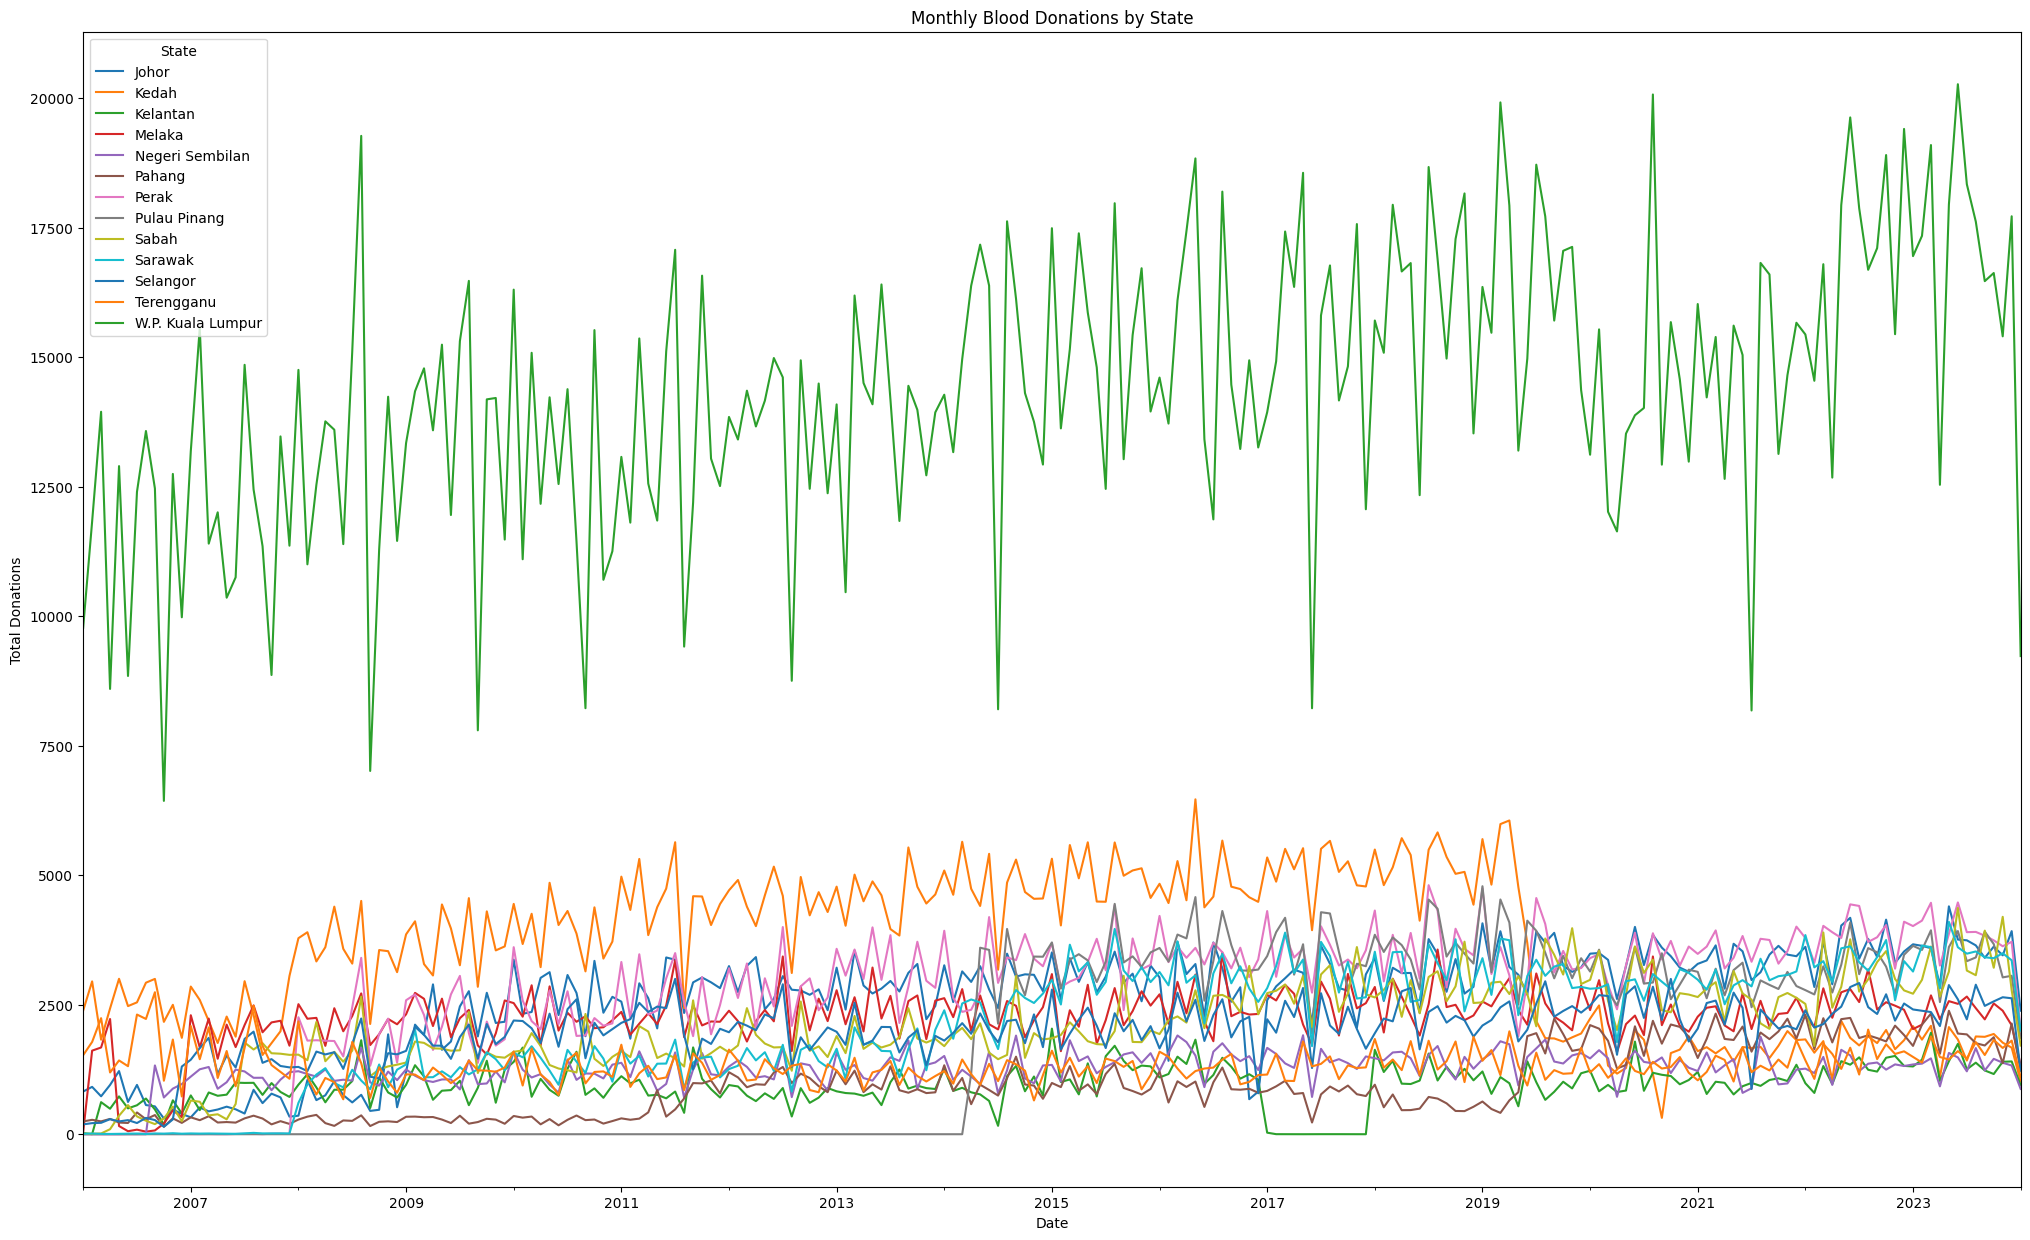

In [8]:
# Group the data by state and resample to a monthly frequency, summing the daily donations
monthly_donations_by_state = state_df.groupby('state').resample('M').sum().loc[:, 'daily']

# Plotting the trends
plt.figure(figsize=(25, 15))
for state in monthly_donations_by_state.index.get_level_values(0).unique():
    monthly_donations_by_state.xs(state, level='state').plot(label=state)
plt.title('Monthly Blood Donations by State')
plt.xlabel('Date')
plt.ylabel('Total Donations')
plt.legend(title='State')
plt.show()


In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose as sm

state_df.reset_index(inplace=True)
monthly_donations_by_state = state_df.groupby(['state', pd.Grouper(key='date', freq='M')])['daily'].sum()

# Pivot the table to have states as columns and dates as rows
monthly_donations_by_state = monthly_donations_by_state.unstack(level=0)

print(monthly_donations_by_state)

state       Johor  Kedah  Kelantan  Melaka  Negeri Sembilan  Pahang  Perak  \
date                                                                         
2006-01-31    824   2386        21      40                0     247      2   
2006-02-28    914   2950         1    1613                0     278      2   
2006-03-31    732   1824       619    1674                0     248      1   
2006-04-30    951   2428       492    2224                1     295      4   
2006-05-31   1219   3000       730     158                0     225      1   
...           ...    ...       ...     ...              ...     ...    ...   
2023-09-30   3404   1880      1231    2217             1231    1713   3832   
2023-10-31   3621   1935      1162    2524             1455    1872   3742   
2023-11-30   3453   1767      1398    2384             1380    1370   3628   
2023-12-31   3920   1671      1405    2102             1326    2137   3714   
2024-01-31   2384   1017       946    1332              875    1

In [20]:
# Proceed with the decomposition as previously
def decompose_and_plot(state, df, mean_donations, model='multiplicative'):
    # Check if the state's data exists in the DataFrame
    if state not in df.columns:
        print(f"No data for state: {state}")
        return
    
    rank = mean_donations.rank(ascending=False)[state]
    
    # Perform seasonal decomposition
    series = df[state].dropna()  # Drop NA values for decomposition
    decomposition = seasonal_decompose(series, model=model, period=12)  # Monthly data usually has a period of 12
    
    # Plot the decomposed components
    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 8))
    decomposition.observed.plot(ax=axes[0], legend=False, title='Observed')
    decomposition.trend.plot(ax=axes[1], legend=False, title='Trend')
    decomposition.seasonal.plot(ax=axes[2], legend=False, title='Seasonal')
    decomposition.resid.plot(ax=axes[3], legend=False, title='Residual')
    
    plt.suptitle(f'Seasonal Decompose of {state} Blood Donations (Rank {int(rank)})')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout
    plt.show()

# Calculate mean donations per state to determine highest and lowest
mean_donations = monthly_donations_by_state.mean().sort_values()

# Take two states with the highest and two with the lowest mean donations
high_states = mean_donations.index[-2:]
low_states = mean_donations.index[:2]

# print(high_states)
# print(low_states)
# Decompose and plot for the selected states
# for state in high_states.union(low_states):
#     decompose_and_plot(state, monthly_donations_by_state, 'multiplicative')

#Doesnt work with multiplicative!


C:\Users\azaid\AppData\Local\Temp\ipykernel_29332\1684182332.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_donations_by_state_ffill = monthly_donations_by_state.fillna(method='ffill')


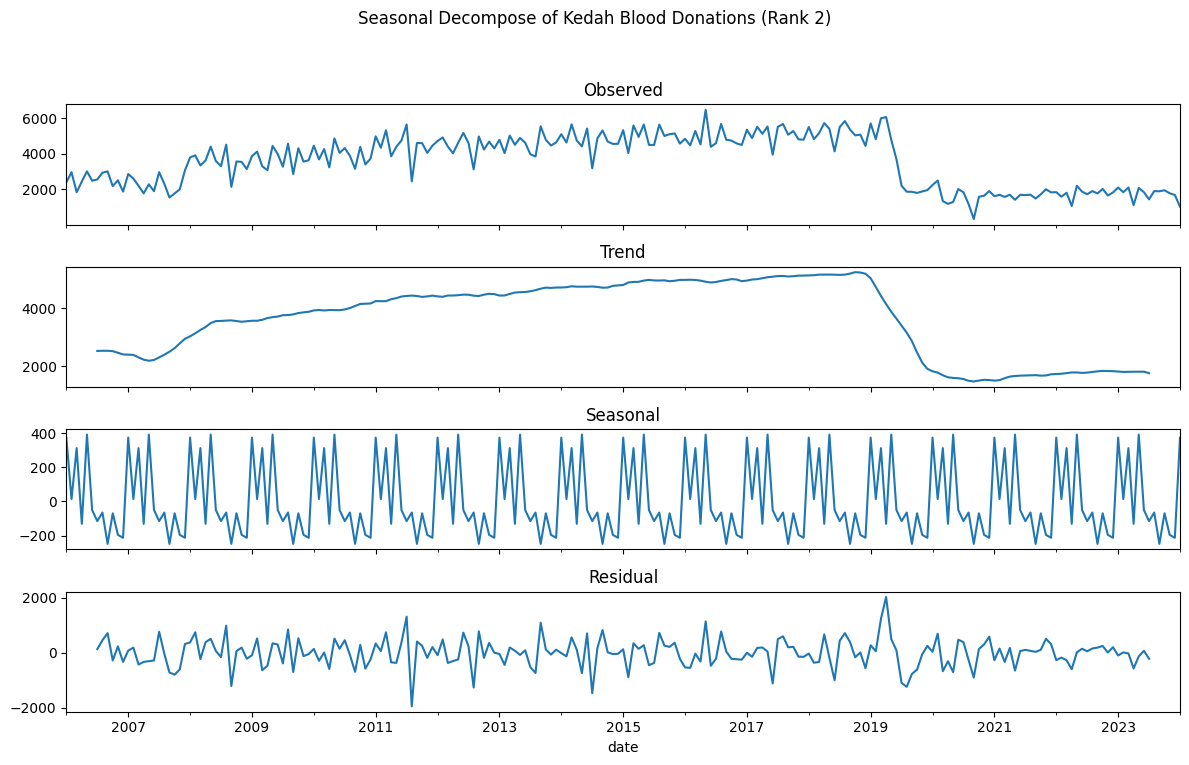

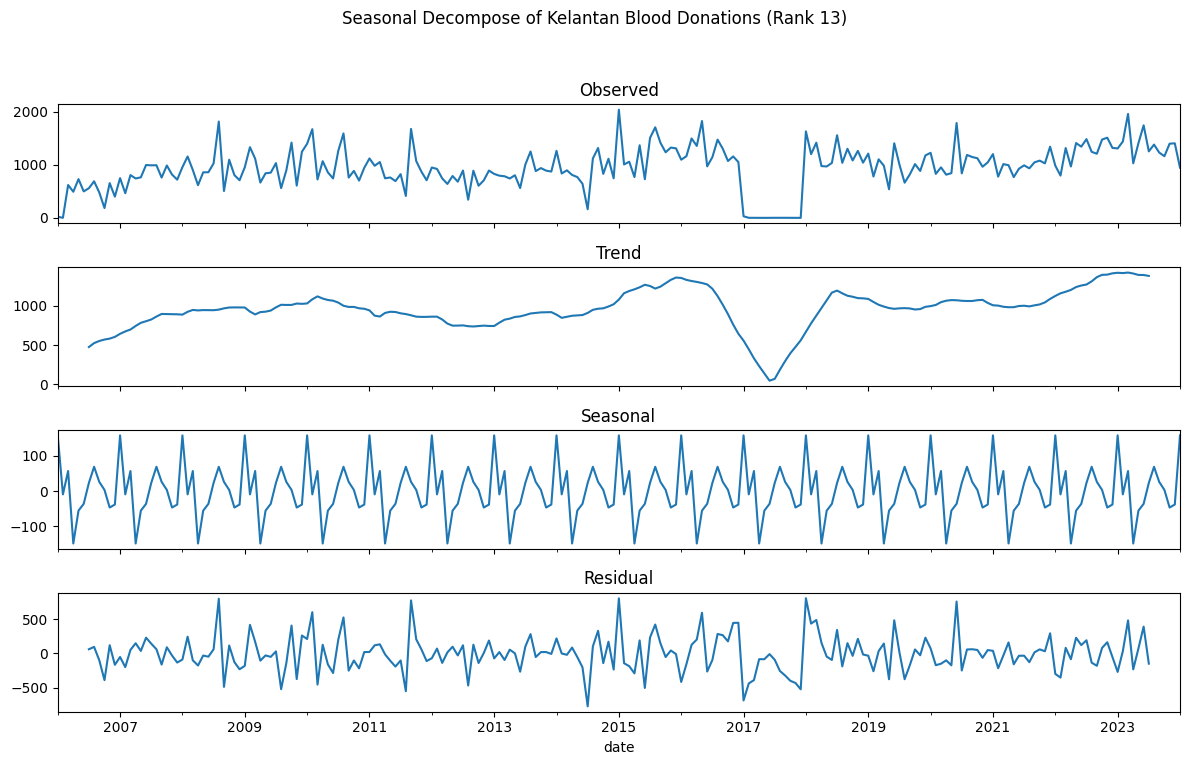

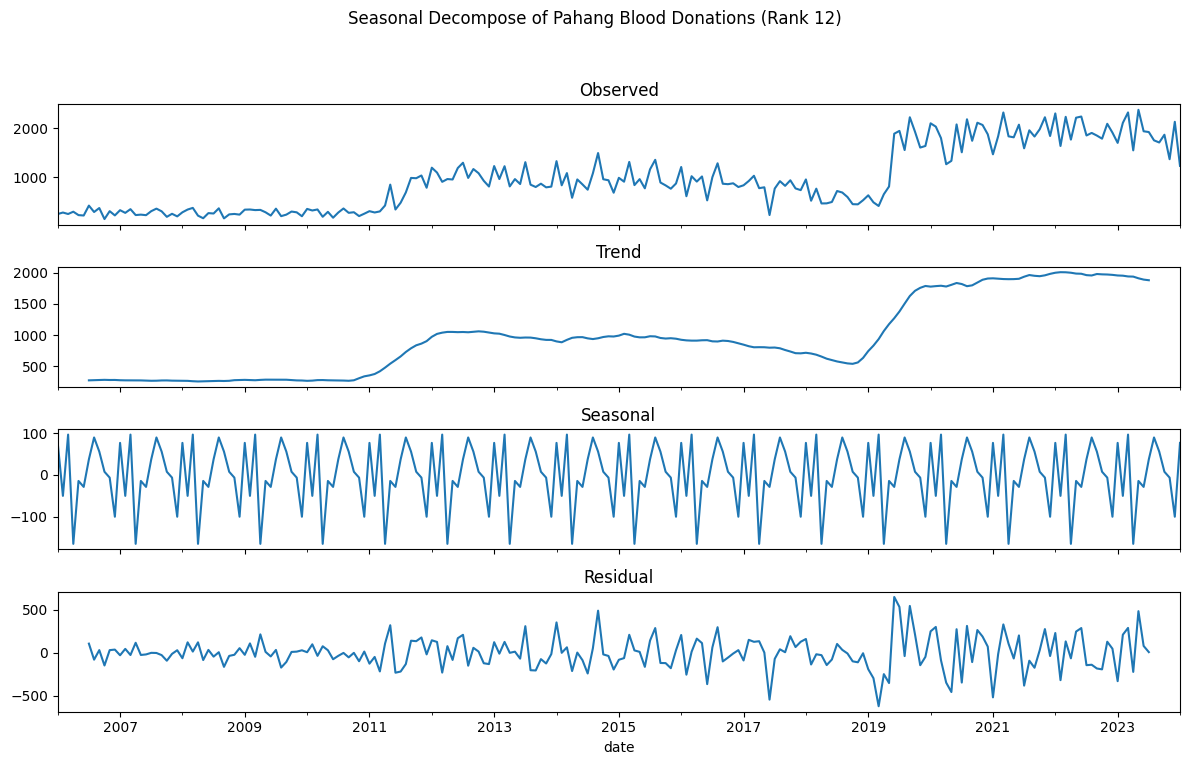

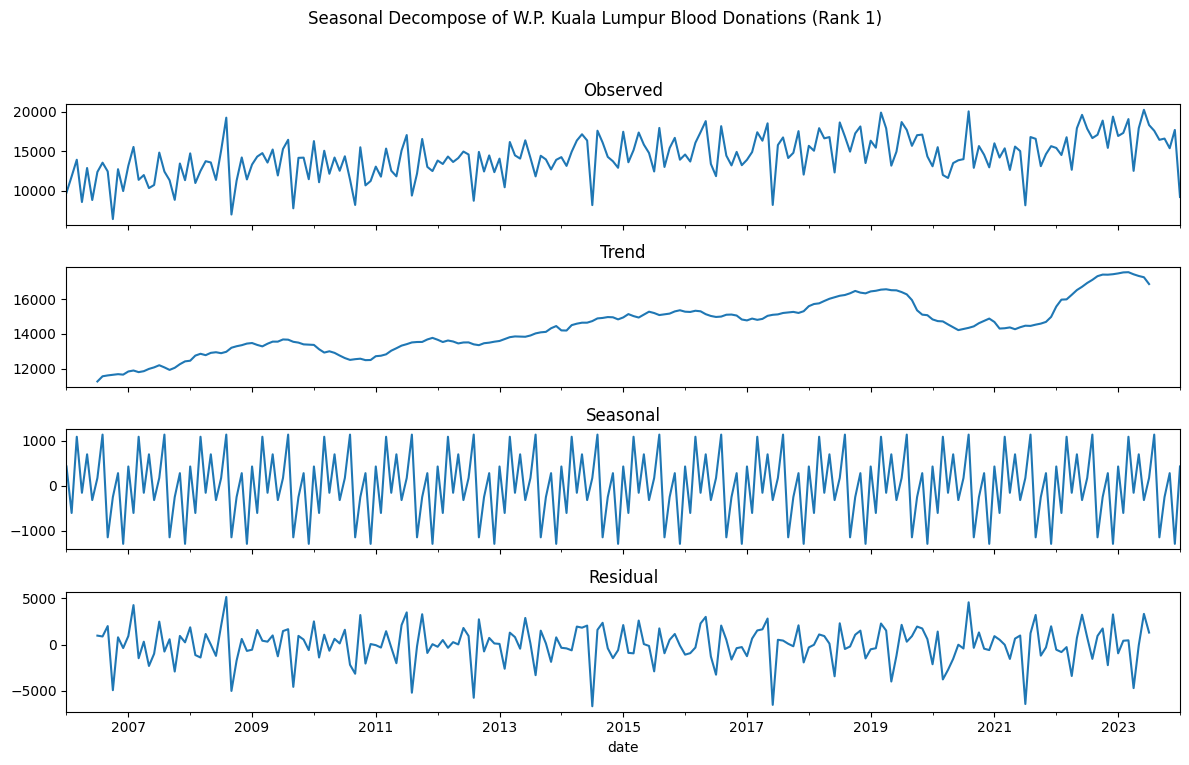

In [21]:
# Forward-fill the donation data for states that started reporting later
monthly_donations_by_state_ffill = monthly_donations_by_state.fillna(method='ffill')

# Replace any remaining NaNs with zeros - assuming these are periods with no donations
monthly_donations_by_state_ffill.fillna(0, inplace=True)

# Ensure there are no negative values in the dataset
monthly_donations_by_state_ffill[monthly_donations_by_state_ffill < 0] = 0

# Now, we can safely proceed with an additive model
# Continue with the decomposition as previously, but using the cleaned data and additive model
for state in high_states.union(low_states):
    decompose_and_plot(state, monthly_donations_by_state_ffill, mean_donations, 'additive')
